<br>**intro**

In [14]:
import $ivy.`org.apache.spark::spark-core:2.4.5`
import $ivy.`org.apache.spark::spark-sql:2.4.5`
import $ivy.`org.apache.spark::spark-mllib:2.4.5`

import $ivy.`ml.dmlc::xgboost4j-spark:0.90`
import $ivy.`ml.dmlc::xgboost4j:0.90`

import $ivy.$                                   

import $ivy.$                                  

import $ivy.$                                    


import $ivy.$                               

import $ivy.$                         

In [15]:
import sys.process._

import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)

import ml.dmlc.xgboost4j.scala.spark.{TrackerConf, XGBoostClassifier, XGBoostClassificationModel}
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.{Pipeline, PipelineModel}

import org.apache.spark.sql._
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._

import org.apache.log4j.{Level, Logger}

import org.apache.spark.sql._

import org.apache.spark.sql.functions._


In [5]:
// val spark = (
//     NotebookSparkSession
//     .builder()
//     .master("local[*]")
//     .getOrCreate()
// )

// import spark.implicits._

In [9]:
val spark = (
    AmmoniteSparkSession
    .builder()
    .master("local[*]")
    .getOrCreate()
)

import spark.implicits._
//Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties

Getting spark JARs
Creating SparkSession


spark: SparkSession = org.apache.spark.sql.SparkSession@2165b8b5
import spark.implicits._
//Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties

In [10]:
def getWebUrl(spark: org.apache.spark.sql.SparkSession) = {
    val hn = ("hostname" !!)stripLineEnd
    val ip = ("hostname --ip-address" !!)stripLineEnd
    val webUrl = spark.sparkContext.uiWebUrl.getOrElse("").asHtml.data("text/html").replace(hn, ip)
    webUrl
}

println(getWebUrl(spark))

http://172.27.1.1:4040


defined function getWebUrl

In [10]:
// spark.catalog.clearCache()
// spark.close()
// spark.stop()

**легенда**

In [10]:
// instanceId_userId — идентификатор пользователя (анонимизированный);
// instanceId_objectType — тип объекта;
// instanceId_objectId — идентификатор объекта (анонимизированный);
// feedback — массив с типами реакций пользователя (наличие в массиве токена Liked говорит о том, что объект получил «класс» от пользователя);
// audit_clientType — тип платформы, с которой зашёл пользователь;
// audit_timestamp — время, когда строилась лента;
// metadata_ownerId — автор показанного объекта (анонимизированный);
// metadata_createdAt — дата создания показанного объекта.

// audit_* — расширенная информация о контексте построения ленты;
// metadata_* — расширенная информация о самом объекте;
// userOwnerCounters_* — информация о предыдущих взаимодействиях пользователя и автора контента;
// ownerUserCounters_* — информация о предыдущих взаимодействиях автора контента и пользователя;
// membership_* — информация о членстве пользователя в группе, где опубликован контент;
// user_* — подробная информация о пользователе;
// auditweights_* — большое количество runtime-признаков, извлечённых текущей системой

**загружаем источник**

In [11]:
val raw_data = "../data/raw/train/"
println((f"du -s -h $raw_data" !!)stripLineEnd)

val df = spark.read.parquet(raw_data) //.cache()

def colName = df.columns.map(col(_)).groupBy(_.toString.split("_")(0))
colName.foreach {case (key, value) => println (f"$key: ${value.length}")}

instanceId: 3
membership: 4
relationsMask: 1
userOwnerCounters: 27
feedback: 1
date: 1
metadata: 14
objectId: 1
audit: 6
owner: 13
ownerUserCounters: 27
auditweights: 58
user: 13


df: DataFrame = [instanceId_userId: int, instanceId_objectType: string ... 167 more fields]
defined function colName

In [12]:
df.printSchema

root
 |-- instanceId_userId: integer (nullable = true)
 |-- instanceId_objectType: string (nullable = true)
 |-- instanceId_objectId: integer (nullable = true)
 |-- audit_pos: long (nullable = true)
 |-- audit_clientType: string (nullable = true)
 |-- audit_timestamp: long (nullable = true)
 |-- audit_timePassed: long (nullable = true)
 |-- audit_experiment: string (nullable = true)
 |-- audit_resourceType: long (nullable = true)
 |-- metadata_ownerId: integer (nullable = true)
 |-- metadata_ownerType: string (nullable = true)
 |-- metadata_createdAt: long (nullable = true)
 |-- metadata_authorId: integer (nullable = true)
 |-- metadata_applicationId: long (nullable = true)
 |-- metadata_numCompanions: integer (nullable = true)
 |-- metadata_numPhotos: integer (nullable = true)
 |-- metadata_numPolls: integer (nullable = true)
 |-- metadata_numSymbols: integer (nullable = true)
 |-- metadata_numTokens: integer (nullable = true)
 |-- metadata_numVideos: integer (nullable = true)
 |-- me

### **ТЗ**

<br> **на рассмотрении** 
<br> 1) **target_userIgnr** - 100% показанных объектов проигнорированно за какой-то критичный промежуток временни - отказ от взаимодействия с предлагаемым контентом
<br> 2) **target_userLost** - наличие ID пользователя за текущий промежуток, на данный срез, с количеством активных коммуникаций больше 0 и отсутвием данного ID в будущем за какой-то промежуток времени

!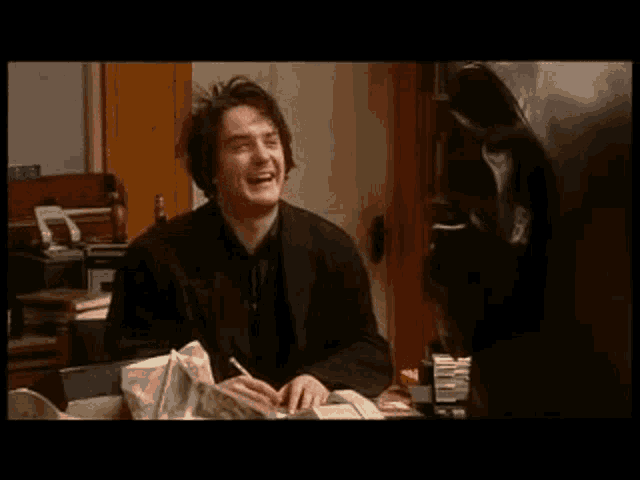

### PART01

<br>**немного увлекательного процессинга**

In [13]:
df.select(explode(coalesce($"feedback", lit(Array("Undefined")))) as "feedback").groupBy("feedback").count().show()

+---------+--------+
| feedback|   count|
+---------+--------+
|Commented|   36244|
|   Viewed|  170031|
| ReShared|  321631|
|  Clicked| 2258630|
|Complaint|     263|
|  Ignored|12421394|
| Disliked| 1665403|
|    Liked| 3220429|
|  Unliked|   33428|
+---------+--------+



In [15]:
// import org.apache.spark.sql.functions

In [16]:
val df1 = df.select(
    $"instanceId_userId" as "useID", 
    $"instanceId_objectId" as "objID", 
    date_format($"audit_timestamp"/1000 cast "timestamp", "yyyy-MM-dd") cast "date" as "auditDate", 
    array_contains($"feedback", "Ignored") cast "Int" as "Ignored"
).cache()

df1: Dataset[Row] = [useID: int, objID: int ... 2 more fields]

In [17]:
df1.show()

+-----+--------+----------+-------+
|useID|   objID| auditDate|Ignored|
+-----+--------+----------+-------+
|  108|18452434|2018-03-04|      0|
|  231|31980032|2018-03-03|      0|
|  423|33834009|2018-03-04|      0|
|  624|25653019|2018-03-04|      1|
|  768|24024934|2018-03-04|      1|
| 1206|25075524|2018-03-04|      1|
| 1752|18132300|2018-03-04|      0|
| 1752| 2402728|2018-03-04|      0|
| 1752|17153719|2018-03-04|      1|
| 2514|19499734|2018-03-04|      1|
| 2823|28484729|2018-03-04|      1|
| 3252|15694836|2018-03-04|      1|
| 4176|34440301|2018-03-04|      1|
| 5646|21385511|2018-03-04|      1|
| 5850|31609830|2018-03-04|      1|
| 6210|21906606|2018-03-04|      1|
| 6366|31404623|2018-03-04|      0|
| 6615|27242106|2018-03-03|      0|
| 6615|  217823|2018-03-03|      1|
| 6798|25242916|2018-03-03|      1|
+-----+--------+----------+-------+
only showing top 20 rows



In [18]:
val df2 = df1.groupBy("useID","auditDate").agg(count($"Ignored") as "cnt_showCont", sum($"Ignored") as "cnt_igndCont").orderBy("useID", "auditDate").cache

df2: Dataset[Row] = [useID: int, auditDate: date ... 2 more fields]

In [19]:
df2.show()

+-----+----------+------------+------------+
|useID| auditDate|cnt_showCont|cnt_igndCont|
+-----+----------+------------+------------+
|    3|2018-03-10|           1|           1|
|    3|2018-03-18|           1|           1|
|    6|2018-03-18|           1|           1|
|    9|2018-02-13|           1|           1|
|   12|2018-02-03|           1|           0|
|   15|2018-02-02|           1|           0|
|   15|2018-02-03|           1|           1|
|   15|2018-02-05|           1|           0|
|   15|2018-02-07|           1|           0|
|   15|2018-02-08|           1|           1|
|   15|2018-02-18|           1|           1|
|   15|2018-02-20|           1|           1|
|   15|2018-03-21|           1|           1|
|   18|2018-03-18|           1|           1|
|   21|2018-02-22|           1|           1|
|   21|2018-03-12|           1|           0|
|   36|2018-02-06|           1|           1|
|   39|2018-02-02|           1|           1|
|   39|2018-02-03|           1|           0|
|   39|201

In [20]:
df2.groupBy().agg(min('auditDate), max('auditDate)).show()

+--------------+--------------+
|min(auditDate)|max(auditDate)|
+--------------+--------------+
|    2018-01-31|    2018-03-21|
+--------------+--------------+



In [21]:
spark.sql(""" select 
cast("2018-01-31" as date) as INF_DATETIME,
cast("2018-01-31" as date) + interval 13 days as FRST_DATESNAP,
cast("2018-03-21" as date) - interval 21 days as LAST_DATESNAP,
datediff("2018-02-28", "2018-02-13") + 1 as SLICE_NUM,
cast("2018-03-21" as date) - interval 20 days as VALID_BEG,
cast("2018-03-21" as date) - interval 14 days as VALID_END,
cast("2018-03-21" as date) as SUP_DATETIME
""").show


+------------+-------------+-------------+---------+----------+----------+------------+
|INF_DATETIME|FRST_DATESNAP|LAST_DATESNAP|SLICE_NUM| VALID_BEG| VALID_END|SUP_DATETIME|
+------------+-------------+-------------+---------+----------+----------+------------+
|  2018-01-31|   2018-02-13|   2018-02-28|       16|2018-03-01|2018-03-07|  2018-03-21|
+------------+-------------+-------------+---------+----------+----------+------------+



In [50]:
val dateRange: Array[String] = spark.sql("SELECT explode(sequence(to_date('2018-02-13'), to_date('2018-02-28'), interval 1 day))").collect.map(_(0).toString)
dateRange.length

dateRange: Array[String] = Array(
  "2018-02-13",
  "2018-02-14",
  "2018-02-15",
  "2018-02-16",
  "2018-02-17",
  "2018-02-18",
  "2018-02-19",
  "2018-02-20",
  "2018-02-21",
  "2018-02-22",
  "2018-02-23",
  "2018-02-24",
  "2018-02-25",
  "2018-02-26",
  "2018-02-27",
  "2018-02-28"
)
res49_1: Int = 16

In [22]:
val df3 = df2.groupBy("useID").agg(
    min('auditDate)   as "min_auditDate", 
    max('auditDate)   as "max_auditDate", 
    datediff(max('auditDate), min('auditDate)) + lit(1) as "days_diff",
    count('auditDate) as "cnt_auditDate",
    sum('cnt_showCont) as "sum_showCont",
    sum('cnt_igndCont)   as "sum_igndCont"
).cache

df3: Dataset[Row] = [useID: int, min_auditDate: date ... 5 more fields]

In [22]:
// df3.orderBy(desc("sum_igndCont")).show
// df3.select("cnt_auditDate").groupBy("cnt_auditDate").count().orderBy(desc("count")).show
// df3.select("days_diff").groupBy("days_diff").count().orderBy(desc("count")).show
// df3.select("sum_showCont").groupBy("sum_showCont").count().orderBy(desc("count")).show

In [23]:
df3.describe().show()

+-------+-----------------+------------------+-----------------+------------------+-----------------+
|summary|            useID|         days_diff|    cnt_auditDate|      sum_showCont|     sum_igndCont|
+-------+-----------------+------------------+-----------------+------------------+-----------------+
|  count|          3916579|           3916579|          3916579|           3916579|          3916579|
|   mean|7906041.699708598|  18.1280558875488|3.685123930859048| 4.669017272471716|3.171490732090429|
| stddev|4508045.648424689|16.736297413902406|4.396073849079898|10.421485813009676|5.905810149292363|
|    min|                3|                 1|                1|                 1|                0|
|    max|         15716685|                50|               50|              1742|              800|
+-------+-----------------+------------------+-----------------+------------------+-----------------+



**сформируем экземпляр сэмпла на примере одного среза (`2018-02-13`) и признаки оттока первого и второго типа**

In [24]:
// относительно текущей даты
val timeslice = lit("2018-02-13") cast "date"

// befor
val interval_befor_beg = timeslice - expr("interval 13 days")
val interval_befor_end = timeslice + expr("interval  0 days")
// after
val interval_after_beg = timeslice + expr("interval  1 days")
val interval_after_end = timeslice + expr("interval 14 days")

val df2_0 = df2.filter($"auditDate".between(interval_befor_beg, interval_after_end))

// отобрать предыдущие две недели для формирования предикторов 
val df2_1 = (
    df2_0
    .filter($"auditDate".between(interval_befor_beg, interval_befor_end))
    .groupBy("useID")
    .agg(
        max('auditDate)   as "closest_auditDate", 
        datediff(interval_befor_end, max('auditDate)) as "days_passed",
        sum('cnt_showCont) as "sum_showCont_befor",
        sum('cnt_igndCont) as "sum_igndCont_befor",
        round(sum('cnt_igndCont)/sum('cnt_showCont), 2) as "ratio_befor")
    .filter("""1=1
    and days_passed <= 7
    and sum_showCont_befor >= 7
    and ratio_befor < 1
    """)
)
.withColumnRenamed("useID", "useID1")
.withColumn("interval_befor", concat_ws("_", date_format(interval_befor_beg,"yyyyMMdd"), date_format(interval_befor_end,"yyyyMMdd"))) // проверочное полее


// отобрать следующие две недели для формирования целевых событий
val df2_2 = (
    df2_0
    .filter($"auditDate".between(interval_after_beg, interval_after_end))
    .groupBy("useID")
    .agg(
        sum('cnt_showCont) as "sum_showCont_after",
        sum('cnt_igndCont) as "sum_igndCont_after",
        round(sum('cnt_igndCont)/sum('cnt_showCont), 2) as "ratio_after")
    .filter("""1=1 
    and sum_showCont_after >= 7
    and ratio_after > 0
    """)
)
.withColumnRenamed("useID", "useID2")
.withColumn("interval_after", concat_ws("_", date_format(interval_after_beg, "yyyyMMdd"), date_format(interval_after_end, "yyyyMMdd"))) // проверочное полее


val df2_3 = (
    df2_1
    .join(
    df2_2, expr("useID1=useID2"), "left"
    )
    .withColumn("target_userLost", ( $"ratio_befor" < lit(1) && $"useID2".isNull) cast "int" )
    .withColumn("target_userIgnr", ( $"ratio_befor" < lit(1) && $"ratio_after" === lit(1))  cast "int" )
)
// 89574

timeslice: Column = CAST(2018-02-13 AS DATE)
interval_befor_beg: Column = (CAST(2018-02-13 AS DATE) - INTERVAL '13 days')
interval_befor_end: Column = (CAST(2018-02-13 AS DATE) + INTERVAL '0 seconds')
interval_after_beg: Column = (CAST(2018-02-13 AS DATE) + INTERVAL '1 days')
interval_after_end: Column = (CAST(2018-02-13 AS DATE) + INTERVAL '14 days')
df2_0: Dataset[Row] = [useID: int, auditDate: date ... 2 more fields]
df2_1: DataFrame = [useID1: int, closest_auditDate: date ... 5 more fields]
df2_2: DataFrame = [useID2: int, sum_showCont_after: bigint ... 3 more fields]
df2_3: DataFrame = [useID1: int, closest_auditDate: date ... 12 more fields]

In [25]:
println("df2_1 counts: " + df2_1.count())
df2_1.show()

println("df2_2 counts: " + df2_2.count())
df2_2.show()

println("df2_3 counts: " + df2_3.count())
df2_3.show()

df2_3.where('useID2 isNotNull).groupBy().agg(max('interval_befor), max('interval_after), count('target_userIgnr), avg('target_userIgnr)).show
df2_3.groupBy().agg(max('interval_befor), max('interval_after), count('target_userLost), avg('target_userLost)).show

println("(ratio_befor_after) pearson R: " + df2_3.stat.corr("ratio_befor", "ratio_after"))


df2_1 counts: 92078
+------+-----------------+-----------+------------------+------------------+-----------+-----------------+
|useID1|closest_auditDate|days_passed|sum_showCont_befor|sum_igndCont_befor|ratio_befor|   interval_befor|
+------+-----------------+-----------+------------------+------------------+-----------+-----------------+
| 89574|       2018-02-10|          3|                13|                10|       0.77|20180131_20180213|
|101055|       2018-02-10|          3|                 7|                 3|       0.43|20180131_20180213|
|144414|       2018-02-12|          1|                 8|                 7|       0.88|20180131_20180213|
|195642|       2018-02-12|          1|                10|                 9|        0.9|20180131_20180213|
|210744|       2018-02-13|          0|                23|                 5|       0.22|20180131_20180213|
|242832|       2018-02-10|          3|                 8|                 7|       0.88|20180131_20180213|
|296865|       20

**отдельно соберем информацию о пользователях**

In [26]:
val user_id = Array($"instanceId_userId".as("userId"))
val user_columns = df.columns.filter(_.contains ("user_")).map(x=>col(x).as(x.replace("user_", "")))

val user_selected_cols = Array(
    $"userId",
    round($"create_date"/1000) cast "int" as "user_create_date",
    $"birth_date" as "user_birth_date",
    $"gender" === lit(1) cast "int" as "user_gender",
    coalesce($"is_active",lit(0)) as "user_is_active", 
    coalesce($"is_deleted",lit(0)) as "user_is_deleted",
    coalesce($"is_abused",lit(0)) as "user_is_abused",
    coalesce($"is_activated",lit(0)) as "user_is_activated"
)

def specWindow(prtBy: String, ordBy: String) = org.apache.spark.sql.expressions.Window.partitionBy(prtBy).orderBy(desc(ordBy))

val user_data = (
    df
    .select(user_id ++ user_columns: _*)
    .distinct
    .withColumn("change_datime", coalesce($"change_datime", $"create_date")/1000 cast "timestamp" )
    .filter($"change_datime".leq(interval_befor_beg))
    .withColumn("max_datime", max("change_datime").over(specWindow("userId", "change_datime")))
    .withColumn("row_datime", row_number().over(specWindow("userId", "change_datime")))
    .filter($"max_datime" === $"change_datime" && $"row_datime" === lit(1))
)
.select(user_selected_cols: _*)


user_id: Array[Column] = Array(instanceId_userId AS `userId`)
user_columns: Array[Column] = Array(
  user_create_date AS `create_date`,
  user_birth_date AS `birth_date`,
  user_gender AS `gender`,
  user_status AS `status`,
  user_ID_country AS `ID_country`,
  user_ID_Location AS `ID_Location`,
  user_is_active AS `is_active`,
  user_is_deleted AS `is_deleted`,
  user_is_abused AS `is_abused`,
  user_is_activated AS `is_activated`,
  user_change_datime AS `change_datime`,
  user_is_semiactivated AS `is_semiactivated`,
  user_region AS `region`
)
user_selected_cols: Array[Column] = Array(
  userId,
  CAST(round((create_date / 1000), 0) AS INT) AS `user_create_date`,
  birth_date AS `user_birth_date`,
  CAST((gender = 1) AS INT) AS `user_gender`,
  coalesce(is_active, 0) AS `user_is_active`,
  coalesce(is_deleted, 0) AS `user_is_deleted`,
  coalesce(is_abused, 0) AS `user_is_abused`,
  coalesce(is_activated, 0) AS `user_is_activated`
)
defined function specWindow
user_data: DataFrame = 

In [27]:
user_data.show()

+------+----------------+---------------+-----------+--------------+---------------+--------------+-----------------+
|userId|user_create_date|user_birth_date|user_gender|user_is_active|user_is_deleted|user_is_abused|user_is_activated|
+------+----------------+---------------+-----------+--------------+---------------+--------------+-----------------+
|  1959|      1176046475|           4663|          1|             1|              0|             0|                1|
|  3918|      1165320190|          -3316|          1|             1|              0|             0|                1|
|  4101|      1182236077|           2187|          0|             1|              0|             0|                1|
|  4818|      1160390997|           2743|          1|             1|              0|             0|                1|
|  6336|      1177166617|          -2440|          0|             1|              0|             0|                1|
|  6357|      1173370992|            514|          1|   

In [28]:
user_data.groupBy("userId").count().groupBy("count").count().show()

+-----+-------+
|count|  count|
+-----+-------+
|    1|3816351|
+-----+-------+



**отберем аттрибуты и саггрегируем до уровня пользователя за период**

In [29]:
def colName = df.columns.map(col(_)).groupBy(_.toString.split("_")(0))
colName.foreach {case (key, value) => println (f"$key: ${value.length}")}

instanceId: 3
membership: 4
relationsMask: 1
userOwnerCounters: 27
feedback: 1
date: 1
metadata: 14
objectId: 1
audit: 6
owner: 13
ownerUserCounters: 27
auditweights: 58
user: 13


defined function colName

In [30]:
val sys_attr = Array(
    $"instanceId_userId" as "useID", 
    $"instanceId_objectId" as "objID", 
    date_format($"audit_timestamp"/1000 cast "timestamp", "yyyy-MM-dd") cast "date" as "auditDate", 
    array_contains($"feedback", "Ignored") cast "Int" as "Ignored"
)
val metadata = Array(
    "metadata_numCompanions", 
    "metadata_numPhotos", 
    "metadata_numPolls", 
    "metadata_numSymbols",  
    "metadata_numTokens",  
    "metadata_numVideos", 
    "metadata_totalVideoLength"
)

val metadata_cols = metadata.map(col).map(x => coalesce(x, lit(0)) as x.toString)
val userOwnerCounters = colName("userOwnerCounters")
val ownerUserCounters = colName("ownerUserCounters")
val auditweights = colName("auditweights")

val features_stack = sys_attr++metadata_cols++(userOwnerCounters++ownerUserCounters++auditweights).map(x => coalesce(x, lit(0)) as x.toString)

val avg_metadata = metadata.map(x => avg(x) alias "avg_"+x)
val avg_userOwnerCounters = userOwnerCounters.map(x => avg(x) alias "avg_"+x)
val avg_ownerUserCounters = ownerUserCounters.map(x => avg(x) alias "avg_"+x)
val avg_auditweights = auditweights.map(x => avg(x) alias "avg_"+x)

val avg_stack = avg_metadata ++ avg_userOwnerCounters ++ avg_ownerUserCounters ++ avg_auditweights

val df_features = (
    df
    .select(features_stack: _*).filter($"auditDate".between(interval_befor_beg, interval_befor_end))
    .groupBy($"useID")
    .agg(avg_stack.head, avg_stack.tail: _*)
)


sys_attr: Array[Column] = Array(
  instanceId_userId AS `useID`,
  instanceId_objectId AS `objID`,
  CAST(date_format(CAST((audit_timestamp / 1000) AS TIMESTAMP), yyyy-MM-dd) AS DATE) AS `auditDate`,
  CAST(array_contains(feedback, Ignored) AS INT) AS `Ignored`
)
metadata: Array[String] = Array(
  "metadata_numCompanions",
  "metadata_numPhotos",
  "metadata_numPolls",
  "metadata_numSymbols",
  "metadata_numTokens",
  "metadata_numVideos",
  "metadata_totalVideoLength"
)
metadata_cols: Array[Column] = Array(
  coalesce(metadata_numCompanions, 0) AS `metadata_numCompanions`,
  coalesce(metadata_numPhotos, 0) AS `metadata_numPhotos`,
  coalesce(metadata_numPolls, 0) AS `metadata_numPolls`,
  coalesce(metadata_numSymbols, 0) AS `metadata_numSymbols`,
  coalesce(metadata_numTokens, 0) AS `metadata_numTokens`,
  coalesce(metadata_numVideos, 0) AS `metadata_numVideos`,
  coalesce(metadata_totalVideoLength, 0) AS `metadata_totalVideoLength`
)
userOwnerCounters: Array[Column] = Array(
  userO

In [30]:
// df_features.show(1,100,true)

In [31]:
df_features.columns.length

res30: Int = 120

**соберем промежуточные датасеты ```df2_3, user_data, df_features``` в финальный ```df_fin```**

In [32]:
val df_fin = df2_3.join(user_data, expr("useID1=userId"), "left").join(df_features, expr("useID1=useID"),"inner")

df_fin: DataFrame = [useID1: int, closest_auditDate: date ... 140 more fields]

In [69]:
println("df_fin counts: " + df_fin.count())
// df_fin.show(1,100,true)

In [34]:
spark.catalog.clearCache()
spark.close()
spark.stop()

### PART02

In [1]:
import $ivy.`org.apache.spark::spark-core:2.4.5`
import $ivy.`org.apache.spark::spark-sql:2.4.5`
import $ivy.`org.apache.spark::spark-mllib:2.4.5`

import $ivy.`ml.dmlc::xgboost4j-spark:1.1.2`
import $ivy.`ml.dmlc::xgboost4j:1.1.2`

import $ivy.$                                   

import $ivy.$                                  

import $ivy.$                                    


import $ivy.$                               

import $ivy.$                         

In [9]:
import sys.process._

import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)

import ml.dmlc.xgboost4j.scala.spark.{TrackerConf, XGBoostClassifier, XGBoostClassificationModel}
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.{Pipeline, PipelineModel}

import org.apache.spark.sql._
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._

import sys.process._


import org.apache.log4j.{Level, Logger}

import ml.dmlc.xgboost4j.scala.spark.{TrackerConf, XGBoostClassifier, XGBoostClassificationModel}

import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator

import org.apache.spark.ml.feature.VectorAssembler

import org.apache.spark.ml.{Pipeline, PipelineModel}


import org.apache.spark.sql._

import org.apache.spark.sql.types._

import org.apache.spark.sql.functions._

In [3]:
val spark = (
    AmmoniteSparkSession
    .builder()
    .master("local[*]")
    .getOrCreate()
)

import spark.implicits._
spark.sparkContext.setLogLevel("FATAL")

def getWebUrl(spark: org.apache.spark.sql.SparkSession) = {
    val hn = ("hostname" !!)stripLineEnd
    val ip = ("hostname --ip-address" !!)stripLineEnd
    val webUrl = spark.sparkContext.uiWebUrl.getOrElse("").asHtml.data("text/html").replace(hn, ip)
    webUrl
}
println(getWebUrl(spark))


Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


http://172.27.1.1:4040


spark: SparkSession = org.apache.spark.sql.SparkSession@71a9ff6d
import spark.implicits._

defined function getWebUrl

<br>**FIN - полный процессинг будет выглядить как:**

In [70]:
def get_processed_df(df: DataFrame, ts: String): DataFrame = {
    
    def colName = df.columns.map(col(_)).groupBy(_.toString.split("_")(0))
    
    val timeslice = lit(ts) cast "date"

    // befor
    val interval_befor_beg = timeslice - expr("interval 13 days")
    val interval_befor_end = timeslice + expr("interval  0 days")
    // after
    val interval_after_beg = timeslice + expr("interval  1 days")
    val interval_after_end = timeslice + expr("interval 14 days")
    
    val df0 = df.filter(
        date_format($"audit_timestamp"/1000 cast "timestamp", "yyyy-MM-dd") cast "date" between(interval_befor_beg, interval_after_end)
    ).cache
    
    val df1 = df0.select(
    $"instanceId_userId" as "useID", 
    $"instanceId_objectId" as "objID", 
    date_format($"audit_timestamp"/1000 cast "timestamp", "yyyy-MM-dd") cast "date" as "auditDate", 
    array_contains($"feedback", "Ignored") cast "Int" as "Ignored"
    ).cache
    
    val df2 = (
        df1
        .groupBy("useID","auditDate")
        .agg(count($"Ignored") as "cnt_showCont", sum($"Ignored") as "cnt_igndCont")
        .orderBy("useID", "auditDate")
        .cache
    )

    // отобрать предыдущие две недели для формирования предикторов 
    val df2_1 = (
        df2
        .filter($"auditDate".between(interval_befor_beg, interval_befor_end))
        .groupBy("useID")
        .agg(
            max('auditDate)   as "closest_auditDate", 
            datediff(interval_befor_end, max('auditDate)) as "days_passed",
            sum('cnt_showCont) as "sum_showCont_befor",
            sum('cnt_igndCont) as "sum_igndCont_befor",
            round(sum('cnt_igndCont)/sum('cnt_showCont), 2) as "ratio_befor")
        .filter("""1=1
        and days_passed <= 7
        and sum_showCont_befor >= 7
        and ratio_befor < 1
        """)
    )
    .withColumnRenamed("useID", "useID1")
    .withColumn("interval_befor", concat_ws("_", date_format(interval_befor_beg,"yyyyMMdd"), date_format(interval_befor_end,"yyyyMMdd"))) // проверочное полее

    // отобрать следующие две недели для формирования целевых событий
    val df2_2 = (
        df2
        .filter($"auditDate".between(interval_after_beg, interval_after_end))
        .groupBy("useID")
        .agg(
            sum('cnt_showCont) as "sum_showCont_after",
            sum('cnt_igndCont) as "sum_igndCont_after",
            round(sum('cnt_igndCont)/sum('cnt_showCont), 2) as "ratio_after")
        .filter("""1=1 
        and sum_showCont_after >= 7
        and ratio_after > 0
        """)
    )
    .withColumnRenamed("useID", "useID2")
    .withColumn("interval_after", concat_ws("_", date_format(interval_after_beg, "yyyyMMdd"), date_format(interval_after_end, "yyyyMMdd"))) // проверочное полее

    // соединяем df2_1 и df2_2
    val df2_3 = (
        df2_1
        .join(
        df2_2, expr("useID1=useID2"), "left"
        )
        .withColumn("target_userLost", ( $"ratio_befor" < lit(1) && $"useID2".isNull) cast "int" )
        .withColumn("target_userIgnr", ( $"ratio_befor" < lit(1) && $"ratio_after" === lit(1))  cast "int" )
    )
    .cache
    
    // userinfo
    
    val user_id = Array($"instanceId_userId".as("userId"))
    val user_columns = df.columns.filter(_.contains ("user_")).map(x=>col(x).as(x.replace("user_", "")))

    val user_selected_cols = Array(
        $"userId",
        round($"create_date"/1000) cast "int" as "user_create_date",
        $"birth_date" as "user_birth_date",
        $"gender" === lit(1) cast "int" as "user_gender",
        coalesce($"is_active",lit(0)) as "user_is_active", 
        coalesce($"is_deleted",lit(0)) as "user_is_deleted",
        coalesce($"is_abused",lit(0)) as "user_is_abused",
        coalesce($"is_activated",lit(0)) as "user_is_activated"
    )

    def specWindow(prtBy: String, ordBy: String) = org.apache.spark.sql.expressions.Window.partitionBy(prtBy).orderBy(desc(ordBy))

    val user_data = (
        df0
        .select(user_id ++ user_columns: _*)
        .distinct
        .withColumn("change_datime", coalesce($"change_datime", $"create_date")/1000 cast "timestamp" )
        .filter($"change_datime".leq(interval_befor_beg))
        .withColumn("max_datime", max("change_datime").over(specWindow("userId", "change_datime")))
        .withColumn("row_datime", row_number().over(specWindow("userId", "change_datime")))
        .filter($"max_datime" === $"change_datime" && $"row_datime" === lit(1))
    )
    .select(user_selected_cols: _*)
    .cache
    
    // feature aggregate
    
    val sys_attr = Array(
        $"instanceId_userId" as "useID", 
        $"instanceId_objectId" as "objID", 
        date_format($"audit_timestamp"/1000 cast "timestamp", "yyyy-MM-dd") cast "date" as "auditDate", 
        array_contains($"feedback", "Ignored") cast "Int" as "Ignored"
    )
    val metadata = Array(
        "metadata_numCompanions", 
        "metadata_numPhotos", 
        "metadata_numPolls", 
        "metadata_numSymbols",  
        "metadata_numTokens",  
        "metadata_numVideos", 
        "metadata_totalVideoLength"
    )

    val metadata_cols = metadata.map(col).map(x => coalesce(x, lit(0)) as x.toString)
    val userOwnerCounters = colName("userOwnerCounters")
    val ownerUserCounters = colName("ownerUserCounters")
    val auditweights = colName("auditweights")

    val features_stack = sys_attr++metadata_cols++(userOwnerCounters++ownerUserCounters++auditweights).map(x => coalesce(x, lit(0)) as x.toString)

    val avg_metadata = metadata.map(x => avg(x) alias "avg_"+x)
    val avg_userOwnerCounters = userOwnerCounters.map(x => avg(x) alias "avg_"+x)
    val avg_ownerUserCounters = ownerUserCounters.map(x => avg(x) alias "avg_"+x)
    val avg_auditweights = auditweights.map(x => avg(x) alias "avg_"+x)

    val avg_stack = avg_metadata ++ avg_userOwnerCounters ++ avg_ownerUserCounters ++ avg_auditweights

    val df_features = (
        df0
        .select(features_stack: _*).filter($"auditDate".between(interval_befor_beg, interval_befor_end))
        .groupBy($"useID")
        .agg(avg_stack.head, avg_stack.tail: _*)
    )
    .cache
    
    val df_fin = df2_3.join(user_data, expr("useID1=userId"), "left").join(df_features, expr("useID1=useID"), "inner")
    val columns_fin = df_fin.columns
    
    df0.unpersist
    df1.unpersist
    df2.unpersist
    df2_3.unpersist
    user_data.unpersist
    df_features.unpersist
    
    df_fin.withColumn("current_date", lit(ts) cast "date").select(("current_date" +: columns_fin).map(col): _*)
}

defined function get_processed_df

<br>**протестируем с сохранением в parquet**

In [71]:
val raw_data = "../data/raw/train/"
println((f"du -s -h $raw_data" !!)stripLineEnd)

val df = (
    spark.read.parquet(raw_data)
    .filter("""1=1
and audit_timestamp > 0 
and instanceId_userId is not null and length(instanceId_userId) > 0
and instanceId_objectId is not null and length(instanceId_objectId) > 0
and metadata_createdAt > 0 
and metadata_createdAt <= audit_timestamp 
and cast((metadata_createdAt/1000) as timestamp) 
    between
    cast((audit_timestamp/1000) as timestamp) - interval 3 month
    and
    cast((audit_timestamp/1000) as timestamp)
    """)
    .cache
)

val _ = df.count

// набор для обучения
val dateRangeTrain: Array[String] = spark.sql("SELECT explode(sequence(to_date('2018-02-13'), to_date('2018-02-28'), interval 1 day))").collect.map(_(0).toString)
for (current_date <- dateRangeTrain) {
    val save_path_train = s"../../external/churn/data/train/${current_date}"
    get_processed_df(df, current_date).write.mode("overwrite").parquet(save_path_train)
}

// набор для валидации
val dateRangeValid: Array[String] = spark.sql("SELECT explode(sequence(to_date('2018-03-01'), to_date('2018-03-07'), interval 1 day))").collect.map(_(0).toString)
for (current_date <- dateRangeValid) {
    val save_path_valid = s"../../external/churn/data/valid/${current_date}"
    get_processed_df(df, current_date).write.mode("overwrite").parquet(save_path_valid)
}

df.unpersist


2.2G	../data/raw/train/


raw_data: String = "../data/raw/train/"
df: Dataset[Row] = [instanceId_userId: int, instanceId_objectType: string ... 167 more fields]
`_`: Long = 18148836L
dateRangeTrain: Array[String] = Array(
  "2018-02-13",
  "2018-02-14",
  "2018-02-15",
  "2018-02-16",
  "2018-02-17",
  "2018-02-18",
  "2018-02-19",
  "2018-02-20",
  "2018-02-21",
  "2018-02-22",
  "2018-02-23",
  "2018-02-24",
  "2018-02-25",
  "2018-02-26",
  "2018-02-27",
  "2018-02-28"
)
dateRangeValid: Array[String] = Array(
  "2018-03-01",
  "2018-03-02",
  "2018-03-03",
  "2018-03-04",
  "2018-03-05",
  "2018-03-06",
  "2018-03-07"
)
res70_8: Dataset[Row] = [instanceId_userId: int, instanceId_objectType: string ... 167 more fields]

In [89]:
println({((f"du -h ../../external/churn/data/train/" !!)stripLineEnd)split("\n")sorted}.mkString("\n"))

30M	../../external/churn/data/train/2018-02-13
30M	../../external/churn/data/train/2018-02-18
30M	../../external/churn/data/train/2018-02-19
30M	../../external/churn/data/train/2018-02-20
30M	../../external/churn/data/train/2018-02-21
30M	../../external/churn/data/train/2018-02-22
30M	../../external/churn/data/train/2018-02-23
31M	../../external/churn/data/train/2018-02-17
31M	../../external/churn/data/train/2018-02-24
32M	../../external/churn/data/train/2018-02-14
32M	../../external/churn/data/train/2018-02-15
32M	../../external/churn/data/train/2018-02-16
33M	../../external/churn/data/train/2018-02-25
33M	../../external/churn/data/train/2018-02-26
34M	../../external/churn/data/train/2018-02-27
34M	../../external/churn/data/train/2018-02-28
496M	../../external/churn/data/train/


In [91]:
println({((f"du -h ../../external/churn/data/valid/" !!)stripLineEnd)split("\n")sorted}.mkString("\n"))

246M	../../external/churn/data/valid/
34M	../../external/churn/data/valid/2018-03-01
34M	../../external/churn/data/valid/2018-03-02
35M	../../external/churn/data/valid/2018-03-03
36M	../../external/churn/data/valid/2018-03-04
36M	../../external/churn/data/valid/2018-03-07
37M	../../external/churn/data/valid/2018-03-05
37M	../../external/churn/data/valid/2018-03-06


<br>**процесс обучение эстиматора ```XGBoostClassifier```**
<font color='red'>
<br>-- WARN: в Альмонде не работает - вынесено в скрипт /external/churn/src/xgbChurnSaveModel.scala
<br>в Intellij IDIA - работает
<br>в spark-shell (spark-master образ в композиции) - работает
</font>
<br> spark 2.4.5 xgboost 0.90
<br> (в образе спарка) apt-get install -y gcc

In [7]:
// // check
// Train.groupBy(Target).agg(min($"ratio_after"), avg($"ratio_after"), max($"ratio_after")).show()
// val quan = Array(0.05, 0.10, 0.20, 0.25, 0.5, 0.75, 0.80, 0.90, 0.95)
// println("target_userIgnr = 1")
// quan.zip(Train.filter("target_userIgnr = 1").stat.approxQuantile("ratio_after", quan, 0)).foreach(println)
// println("target_userIgnr = 0")
// quan.zip(Train.filter("target_userIgnr = 0").stat.approxQuantile("ratio_after", quan, 0)).foreach(println)

#### листинг: <br>**cat /external/churn/src/xgbChurnSaveModel.scala**

In [ ]:
import ml.dmlc.xgboost4j.scala.spark.{TrackerConf, XGBoostClassifier, XGBoostClassificationModel}
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.Pipeline
import org.apache.spark.sql._
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._
spark.sparkContext.setLogLevel("FATAL")

// LOAD DATA
val save_path_train = s"../../external/churn/data/train/*"
val save_path_valid = s"../../external/churn/data/valid/*"
val df_train = spark.read.parquet(save_path_train)
val df_valid = spark.read.parquet(save_path_valid)

def getStats(Data: DataFrame, Target: String) = {
    val nrows = Data.count
    val ncols = Data.columns.length
    val props = Data.select(Target).groupBy().agg(avg(col(Target))).take(1)(0).get(0).toString.toFloat
Array(nrows, ncols, props)}

val Target = "target_userIgnr"

val Train = df_train.where($"useID2".isNotNull && $"ratio_befor" < lit(1.0) && col(Target).isNotNull).na.fill(0)
val Valid = df_valid.where($"useID2".isNotNull && $"ratio_befor" < lit(1.0) && col(Target).isNotNull).na.fill(0)

// Train.printSchema
// Valid.printSchema

// GET STATS
val statTrain = getStats(Train, Target)
val statValid = getStats(Valid, Target)
Train.groupBy("current_date").agg(count($"useID1"), avg(col(Target))).orderBy("current_date").show
Valid.groupBy("current_date").agg(count($"useID1"), avg(col(Target))).orderBy("current_date").show

// SET PIPELINE PARAMS
val exclude_name = "current_date,useID1,closest_auditDate,interval_befor,useID2,ratio_after,sum_showCont_after,sum_igndCont_after,interval_after,userId,useID,target_userLost".split(",") ++ Array(Target)
val exclude_type = Array(StringType, TimestampType, DateType)
val main_cols = Train.schema.fields.filterNot(f => exclude_type contains f.dataType).filterNot(f => exclude_name contains f.name).map(x => x.name)

val pos_wei = (1-statTrain(2))/statTrain(2)
val parallelizm = 4
val xgbParam: Map[String, Any] = Map(
    "missing" -> 0,
    "objective" -> "binary:logistic",
    "eval_metric" ->  "logloss",
    "eta" -> 0.01,
    "max_depth" -> 3,
    "num_round" -> 200,
    "subsample" -> 0.7,
    "min_child_weight" -> 100,
    "scale_pos_weight" -> pos_wei.toInt,
    "num_workers" -> parallelizm,
    "verbosity" -> 1,
    "tracker_conf" -> TrackerConf(60*60*1000, "scala"),
    "kill_spark_context_on_worker_failure" -> false
)


// TRAIN MODEL PIPELINE
val vectorAssembler = new VectorAssembler().setInputCols(main_cols).setOutputCol("features")
val xgbClassifier = new XGBoostClassifier(xgbParam).setFeaturesCol("features").setLabelCol(Target)
val pipeModel = new Pipeline().setStages(Array(vectorAssembler, xgbClassifier))

val xgbPipelineModel = pipeModel.fit(Train)
xgbPipelineModel.write.overwrite().save(s"../../external/churn/model/xgb_pipeline")

def printMetric(spark: org.apache.spark.sql.SparkSession, data: DataFrame, label: String) = {
    val v0 = udf((v: org.apache.spark.ml.linalg.Vector) => v.toArray(0))
    val v1 = udf((v: org.apache.spark.ml.linalg.Vector) => v.toArray(1))
    val evaluator = new BinaryClassificationEvaluator().setLabelCol(label).setRawPredictionCol("probability").setMetricName("areaUnderROC")
    val result = xgbPipelineModel.transform(data).withColumn("score", v1($"probability"))
    val rocauc = evaluator.evaluate(result)
    println("ROCAUC: " + rocauc.toString)
    val query =s"""
      |SELECT --*
      | avg(${label}) as target_avg,
      | avg(CASE WHEN t.nn <= t.cnt*0.01 THEN t.${label} ELSE Null END) as q001,
      | avg(CASE WHEN t.nn <= t.cnt*0.05 THEN t.${label} ELSE Null END) as q005,
      | avg(CASE WHEN t.nn <= t.cnt*0.10 THEN t.${label} ELSE Null END) as q010,
      | avg(CASE WHEN t.nn <= t.cnt*0.15 THEN t.${label} ELSE Null END) as q015
      |FROM
      |   (SELECT ${label}, score, row_number() over(order by score desc) as nn, count(*) over() as cnt FROM RESULT order by score DESC) t
      |""".stripMargin
    result.select(label, "score").createOrReplaceTempView("RESULT")
    spark.sql(query).show()
}

// METRIC ON TRAIN
printMetric(spark, Train, Target)
// METRIC ON VALID
printMetric(spark, Valid, Target)

spark.catalog.clearCache()
spark.close()
spark.stop()

<br>**<font color='red'>TODO: разгуглить ошибку, сделать чтобы запускалось<font>**

In [91]:
// val xgbClassificationModel = xgbClassifier.fit(xgbTrain)

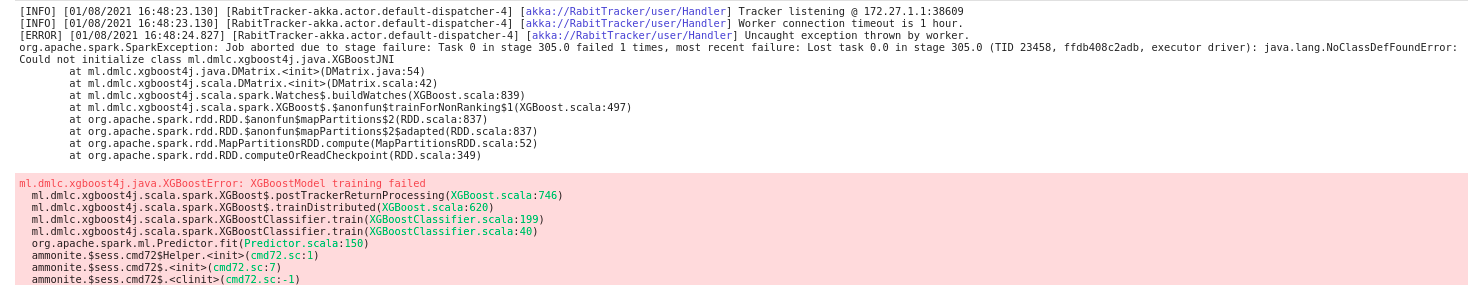

####  <br>**вынесено в ```/external/churn/src/xgbChurnSaveModel.scala```**
####  **контейнер: sudo docker exec -it spark-master /bin/bash**
####  **запуск ```bash -x /external/churn/spark_shell_run_scala.sh```**
```cat /external/churn/src/xgbChurnSaveModel.scala | /spark/bin/spark-shell --packages "ml.dmlc:xgboost4j:0.81,ml.dmlc:xgboost4j-spark:0.90" | tee -a "/external/churn/logs/xgb_spark_track_$(date -d "today" +"%Y%m%d%H%M%S").log"```
<br>
<br>**<font color='red'>TODO: собрать fat-jar<font>**

<br>**загрузим полученный эстиматор**

helpers
<br> https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
<br> https://alvinalexander.com/scala/how-to-sort-map-in-scala-key-value-sortby-sortwith/

In [81]:
val Train = spark.read.parquet("../../external/churn/data/train/*")
val Valid = spark.read.parquet("../../external/churn/data/valid/*")

val xgbPipes = PipelineModel.load("../../external/churn/model/xgb_pipeline/")
val xgbModel = xgbPipes.stages(1).asInstanceOf[XGBoostClassificationModel]
val mainCols = xgbPipes.stages(0).asInstanceOf[VectorAssembler].getInputCols
mainCols.length
def xgbImportance(booster: XGBoostClassificationModel, impType: String, colName: Array[String]): Map[String, Double] = {
    // Available 
    val importance_types = Array("weight", "gain", "cover", "total_gain", "total_cover")
    booster.nativeBooster.getScore(colName, impType)
}


Train: DataFrame = [current_date: date, useID1: int ... 141 more fields]
Valid: DataFrame = [current_date: date, useID1: int ... 141 more fields]
xgbPipes: PipelineModel = pipeline_dd511a9ec8a9
xgbModel: XGBoostClassificationModel = xgbc_43c6a3205bda
mainCols: Array[String] = Array(
  "days_passed",
  "sum_showCont_befor",
  "sum_igndCont_befor",
  "ratio_befor",
  "user_create_date",
  "user_birth_date",
  "user_gender",
  "user_is_active",
  "user_is_deleted",
  "user_is_abused",
  "user_is_activated",
  "avg_metadata_numCompanions",
  "avg_metadata_numPhotos",
  "avg_metadata_numPolls",
  "avg_metadata_numSymbols",
  "avg_metadata_numTokens",
  "avg_metadata_numVideos",
  "avg_metadata_totalVideoLength",
  "avg_userOwnerCounters_USER_FEED_REMOVE",
  "avg_userOwnerCounters_USER_PROFILE_VIEW",
  "avg_userOwnerCounters_VOTE_POLL",
  "avg_userOwnerCounters_USER_SEND_MESSAGE",
  "avg_userOwnerCounters_USER_DELETE_MESSAGE",
  "avg_userOwnerCounters_USER_INTERNAL_LIKE",
  "avg_userOwnerCou

In [77]:
xgbImportance(xgbModel,  "weight", mainCols).toSeq.sortWith(_._2 > _._2).slice(0,10)

res76: Seq[(String, Double)] = Vector(
  ("ratio_befor", 395.0),
  ("sum_showCont_befor", 304.0),
  ("avg_userOwnerCounters_USER_FEED_REMOVE", 141.0),
  ("avg_auditweights_userOwner_USER_FEED_REMOVE", 132.0),
  ("avg_auditweights_isRandom", 115.0),
  ("avg_auditweights_svd_prelaunch", 108.0),
  ("avg_auditweights_matrix", 65.0),
  ("avg_userOwnerCounters_CREATE_LIKE", 64.0),
  ("avg_metadata_numPolls", 15.0),
  ("avg_auditweights_userOwner_CREATE_LIKE", 12.0)
)

In [78]:
xgbImportance(xgbModel,  "gain", mainCols).toSeq.sortWith(_._2 > _._2).slice(0,10)

res77: Seq[(String, Double)] = Vector(
  ("avg_auditweights_isRandom", 31055.011966440885),
  ("avg_userOwnerCounters_USER_FEED_REMOVE", 26587.09794117872),
  ("ratio_befor", 8628.358282171132),
  ("sum_showCont_befor", 8195.567966887496),
  ("avg_auditweights_svd_prelaunch", 6135.394249027781),
  ("avg_auditweights_matrix", 5038.240797846153),
  ("avg_userOwnerCounters_CREATE_LIKE", 4986.280462484374),
  ("avg_auditweights_friendLikes_actors", 641.724792),
  ("avg_userOwnerCounters_IMAGE", 633.927124),
  ("sum_igndCont_befor", 474.54914436363634)
)

In [79]:
xgbImportance(xgbModel,  "cover", mainCols).toSeq.sortWith(_._2 > _._2).slice(0,10)

res78: Seq[(String, Double)] = Vector(
  ("avg_auditweights_isRandom", 169691.876730087),
  ("avg_userOwnerCounters_CREATE_LIKE", 162706.69518367187),
  ("avg_userOwnerCounters_USER_FEED_REMOVE", 154098.93384666668),
  ("avg_auditweights_svd_prelaunch", 147696.85906398145),
  ("avg_auditweights_matrix", 146528.57477692308),
  ("sum_showCont_befor", 140826.80186894737),
  ("ratio_befor", 113416.21500605062),
  ("avg_auditweights_userOwner_USER_FEED_REMOVE", 21211.42631962122),
  ("avg_metadata_numPolls", 12438.957839333332),
  ("avg_userOwnerCounters_UNKNOWN", 11906.138856000001)
)

<br> **сохраним модель для получения shap-values в python - НЕ ЗАВЕЛОСЬ**

In [82]:
// xgbModel.nativeBooster.saveModel("../../external/churn/model/xgb_native.json")

In [83]:
Train.coalesce(1)       
  .write             
  .mode("overwrite") 
  .option("header", "true")
  .option("delimiter","\t")
  .csv("../../external/churn/data/shap")

In [85]:
spark.catalog.clearCache()
spark.close()
spark.stop()